In [1]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm

from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

In [2]:
#DO NOT RUN IF YOU DO NOT WANT TO GENERATE NEW DATA
#data_path = './MindBigData-EP-v1.0/EP1.01.txt'
#split_main_data(data_path=data_path, output_folder='./MindBigData-EP-v1.0')

Load the files, get the points and the list of labels

In [3]:
files = glob.glob('./MindBigData-EP-v1.0/*.csv')
all_points, all_labels = files_to_datapoints(files, first_n=len(files)) #first_n = 500 by default. Apply first_n = len(files) to load all

100%|██████████| 65034/65034 [01:47<00:00, 605.26it/s]


In [4]:
print("Num points:", len(all_points))
print("Num labels:", len(all_labels))
print("Labels:", all_labels)

Num points: 64629
Num labels: 11
Labels: ['0', '-1', '8', '6', '2', '1', '3', '9', '4', '5', '7']


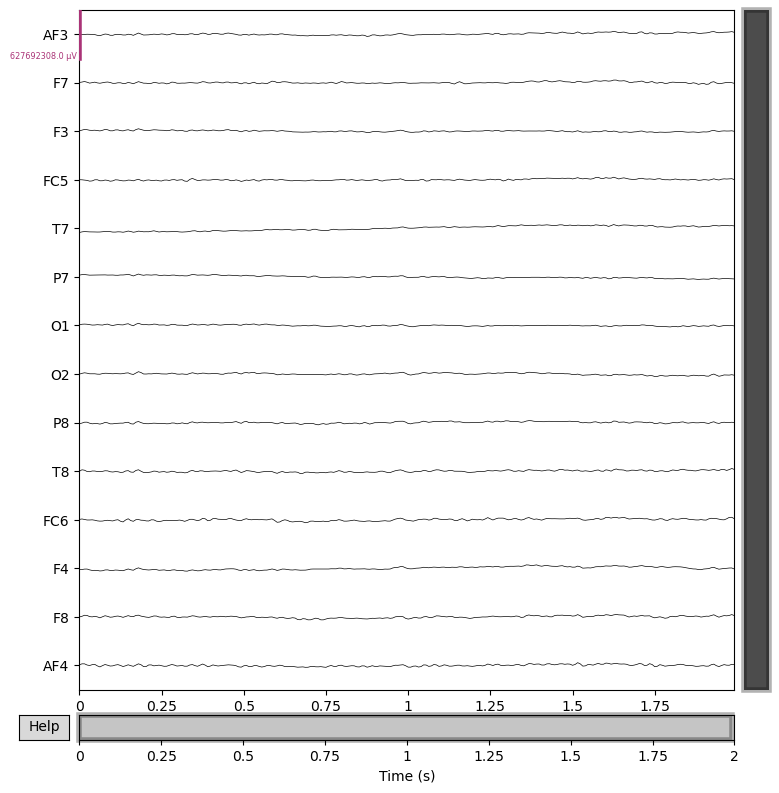

In [5]:
all_points[234].mne_object.plot(scalings = 'auto'); #Pre-cleaning

In [6]:
"""
We will loop through every data point and call the cleaning methods.
This filters the frequencies to be only between the ranges. We want 3 - 30 because this is where relevant alpha theta, beta bands lie.
MNE says to multiply the lowpass by 1/3.
"""
for point in tqdm(all_points):
    #T7, P7, P8, T8 have been shown to be the most involved in image recognition
    """point.crop_to_channels(['T7', 'P7', 'P8', 'T8'])
    point.average_reference()
    point.filter_mne(3, 30)"""
    point.full_clean(channels = ['T7', 'P7', 'P8', 'T8'], l_freq = 3, h_freq = 30)


100%|██████████| 64629/64629 [02:24<00:00, 447.30it/s]


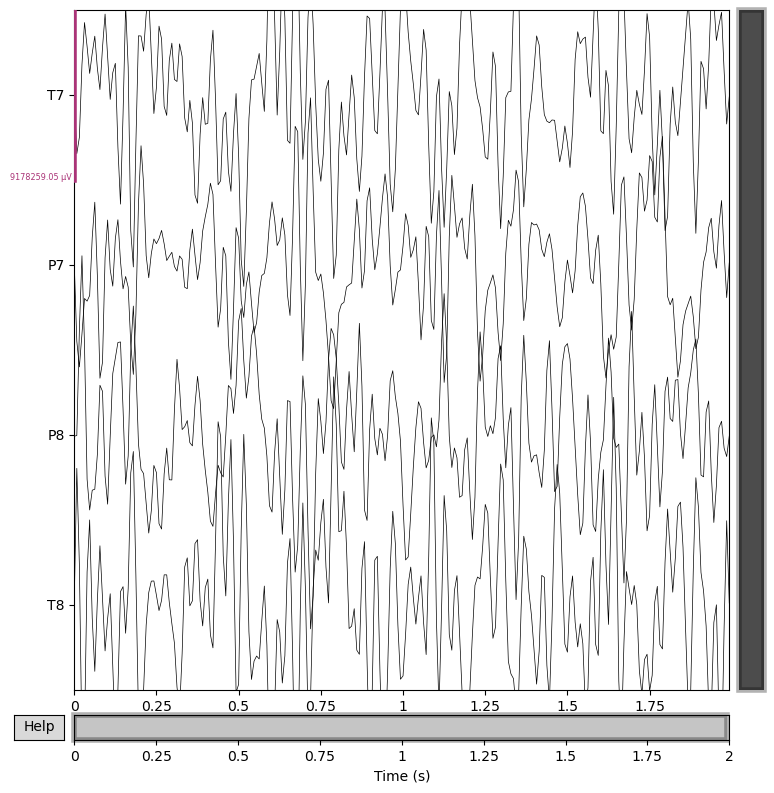

In [7]:
all_points[234].mne_object.plot(scalings='auto');

Autoencoder with the goal of anomally detection.

In [32]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
from torch.optim import Adam, SGD
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss
from EegAutoencoder import Encoder, Decoder, Autoencoder
from tqdm.notebook import tqdm

In [33]:
batch_size = 32
num_workers = 4

dataset = EegDataset(data_points=all_points, labels=all_labels)
train, test = train_test_split(dataset, train_size=0.8, shuffle=True)

train_dataloader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [34]:
input = next(train_dataloader.__iter__())[0]
input.shape

torch.Size([32, 1, 256, 4])

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

latent_dim = 200

encoder = Encoder(latent_dim = latent_dim)
decoder = Decoder(latent_dim = latent_dim)

model = Autoencoder(decoder=decoder, encoder=encoder, device=device).to(device=device)

optimizer = Adam(model.parameters(), lr=0.0001)
loss_function = MSELoss()

n_epochs = 200

for epoch in range(n_epochs):
    
    print(f'Epoch {epoch+1}/{n_epochs}')
    model.train()
    train_loss = 0.0

    for data, label in tqdm(train_dataloader):
        
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = loss_function(output, data)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data
    
    train_loss/=(len(train_dataloader))
    
    print('Epoch Loss:', train_loss.item())


cuda
Epoch 1/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 103.3659896850586
Epoch 2/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 102.13158416748047
Epoch 3/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 101.23353576660156
Epoch 4/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 97.91302490234375
Epoch 5/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 94.20478820800781
Epoch 6/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 93.58487701416016
Epoch 7/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 97.04846954345703
Epoch 8/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 95.49449157714844
Epoch 9/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 91.4009017944336
Epoch 10/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 95.76091766357422
Epoch 11/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 92.68443298339844
Epoch 12/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 93.30363464355469
Epoch 13/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 91.0273208618164
Epoch 14/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 92.81912994384766
Epoch 15/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 87.94766235351562
Epoch 16/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 86.43185424804688
Epoch 17/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 85.65758514404297
Epoch 18/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 83.04302978515625
Epoch 19/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 81.693359375
Epoch 20/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 81.48672485351562
Epoch 21/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 81.58937072753906
Epoch 22/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 77.04053497314453
Epoch 23/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 76.69279479980469
Epoch 24/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 79.10006713867188
Epoch 25/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 76.75179290771484
Epoch 26/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 76.78886413574219
Epoch 27/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 76.37303161621094
Epoch 28/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 80.51099395751953
Epoch 29/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 78.06085205078125
Epoch 30/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 70.7852554321289
Epoch 31/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 66.77606201171875
Epoch 32/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 65.53028869628906
Epoch 33/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 64.1847915649414
Epoch 34/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 69.0373764038086
Epoch 35/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 66.10591888427734
Epoch 36/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 67.49764251708984
Epoch 37/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 68.20886993408203
Epoch 38/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 65.533935546875
Epoch 39/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 57.6799430847168
Epoch 40/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 59.435508728027344
Epoch 41/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 59.66939163208008
Epoch 42/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 61.920127868652344
Epoch 43/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 74.93405151367188
Epoch 44/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 57.8330192565918
Epoch 45/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 54.9588623046875
Epoch 46/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 56.08755874633789
Epoch 47/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 54.047637939453125
Epoch 48/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 52.19247817993164
Epoch 49/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 55.65821838378906
Epoch 50/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 51.65022659301758
Epoch 51/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 53.07466506958008
Epoch 52/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 55.56671905517578
Epoch 53/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 50.52942657470703
Epoch 54/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 53.89607238769531
Epoch 55/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 55.30134201049805
Epoch 56/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 52.2580451965332
Epoch 57/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 54.19435501098633
Epoch 58/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 50.8962516784668
Epoch 59/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 50.9603271484375
Epoch 60/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 47.07823181152344
Epoch 61/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 46.95108413696289
Epoch 62/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 52.728233337402344
Epoch 63/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 47.723167419433594
Epoch 64/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 54.064598083496094
Epoch 65/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 53.69572830200195
Epoch 66/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 47.68269348144531
Epoch 67/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 49.14055252075195
Epoch 68/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 48.70586013793945
Epoch 69/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 48.48745346069336
Epoch 70/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 54.796852111816406
Epoch 71/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 46.36073684692383
Epoch 72/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 45.648197174072266
Epoch 73/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 42.038143157958984
Epoch 74/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 45.369285583496094
Epoch 75/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 51.0703239440918
Epoch 76/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 43.573246002197266
Epoch 77/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 43.37107467651367
Epoch 78/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 43.201663970947266
Epoch 79/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 44.127384185791016
Epoch 80/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 49.473167419433594
Epoch 81/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 48.1186408996582
Epoch 82/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 41.5091552734375
Epoch 83/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 43.83089065551758
Epoch 84/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 44.4931640625
Epoch 85/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 45.397212982177734
Epoch 86/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 39.403350830078125
Epoch 87/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 39.6457405090332
Epoch 88/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 43.666324615478516
Epoch 89/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 42.2120475769043
Epoch 90/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 43.40127944946289
Epoch 91/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 37.90530014038086
Epoch 92/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 47.55899429321289
Epoch 93/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 43.54814529418945
Epoch 94/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 36.941646575927734
Epoch 95/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 41.70052719116211
Epoch 96/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 48.34697341918945
Epoch 97/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 50.26110076904297
Epoch 98/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 36.571189880371094
Epoch 99/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 40.464111328125
Epoch 100/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch Loss: 40.4444580078125


In [44]:
loss = 0.0
for data, label in test_dataloader:
    data = data.to(device)
    prediction = model(data)
    loss += loss_function(data, prediction)
loss /= len(test_dataloader)
print('Test loss:',loss.item())


Test loss: 68.78784942626953
